# BFS Performance Comparison (Local vs Parallel)

Inspect BFS latencies collected from the local and parallel benchmark runs stored in `benchmark_local.json` and `benchmark_parallel_run0.json`. The notebook focuses on the BFS-only measurements and contrasts their behavior over time and by start vertex.


In [1]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

plt.style.use("ggplot")
pd.set_option("display.max_rows", 20)
pd.options.display.float_format = "{:.3f}".format


/home/parshan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [9]:
DATA_ROOT = Path("/home/parshan/tinygraph")
LOCAL_PATH = DATA_ROOT / "benchmark_local.json"
PARALLEL_PATH = DATA_ROOT / "benchmark_parallel_optimized.json"
PARALLEL_NAIVE_PATH = DATA_ROOT / "benchmark_parallel_naive.json"


def load_bfs_measurements(path: Path, label: str):
    """Load BFS-only records while preserving config + summary metadata."""
    with path.open() as f:
        payload = json.load(f)

    measurements = payload.get("measurements", [])
    if not measurements:
        raise ValueError(f"No measurements found in {path}")

    df = pd.DataFrame(measurements)
    bfs_df = df[df["operation"] == "bfs"].copy()
    if bfs_df.empty:
        raise ValueError(f"No BFS entries present in {path}")

    bfs_df["dataset"] = label
    bfs_df["timestamp"] = pd.to_datetime(bfs_df["timestamp"], utc=True)
    
    # Convert rtt_ms to float, and if it's 0 or missing, calculate from rtt_ns
    bfs_df["rtt_ms"] = bfs_df["rtt_ms"].astype(float)
    if "rtt_ns" in bfs_df.columns:
        # Convert nanoseconds to milliseconds where rtt_ms is 0 or missing
        mask = (bfs_df["rtt_ms"] == 0) | bfs_df["rtt_ms"].isna()
        bfs_df.loc[mask, "rtt_ms"] = bfs_df.loc[mask, "rtt_ns"].astype(float) / 1_000_000
    
    bfs_df["checkpoint"] = bfs_df["checkpoint"].astype(int)
    bfs_df = bfs_df.sort_values(["checkpoint", "timestamp"]).reset_index(drop=True)

    return bfs_df, payload.get("config", {}), payload.get("summary", {})


In [10]:
local_bfs, local_cfg, local_summary = load_bfs_measurements(LOCAL_PATH, "local")
parallel_bfs, parallel_cfg, parallel_summary = load_bfs_measurements(PARALLEL_PATH, "parallel")
parallel_naive_bfs, parallel_naive_cfg, parallel_naive_summary = load_bfs_measurements(PARALLEL_NAIVE_PATH, "parallel_naive")

bfs_df = pd.concat([local_bfs, parallel_bfs, parallel_naive_bfs], ignore_index=True)

print("Loaded BFS samples:")
display(
    bfs_df.groupby("dataset")["checkpoint"].agg(["count", "min", "max"])
)

print("\nFirst few rows:")
display(bfs_df.head(10))


Loaded BFS samples:


,count,min,max
dataset,,,
local,25,1,5
parallel,25,1,5
parallel_naive,25,1,5



First few rows:


,operation,rtt_ns,rtt_ms,checkpoint,bfs_start,bfs_radius,bfs_result,timestamp,dataset,vertex_from,vertex_to
0,bfs,241319,0.241,1,0,10.000,"[0, 208, 304, 1, 33, 512, 20, 257, 161, 320, 1...",2025-11-27 01:23:51.932006906+00:00,local,NaN,NaN
1,bfs,212189,0.212,1,1,10.000,"[1, 68, 131, 232, 544, 130, 256, 258, 504, 529...",2025-11-27 01:23:51.932220885+00:00,local,NaN,NaN
2,bfs,187050,0.187,1,2,10.000,"[2, 3, 129, 514, 160, 161, 392, 73, 64, 97, 36...",2025-11-27 01:23:51.932409225+00:00,local,NaN,NaN
3,bfs,158939,0.159,1,4,10.000,"[4, 528, 725, 170, 162, 25, 276, 448, 293, 32,...",2025-11-27 01:23:51.932569514+00:00,local,NaN,NaN
4,bfs,194790,0.195,1,3,10.000,"[3, 536, 512, 652, 16, 18, 580, 617, 326, 36, ...",2025-11-27 01:23:51.932764754+00:00,local,NaN,NaN
5,bfs,330449,0.330,2,0,10.000,"[0, 208, 304, 1, 33, 512, 20, 257, 161, 320, 1...",2025-11-27 01:23:51.933439442+00:00,local,NaN,NaN
6,bfs,314229,0.314,2,1,10.000,"[1, 68, 131, 232, 544, 130, 256, 258, 504, 529...",2025-11-27 01:23:51.933754301+00:00,local,NaN,NaN
7,bfs,297909,0.298,2,2,10.000,"[2, 3, 129, 514, 160, 161, 392, 73, 64, 97, 36...",2025-11-27 01:23:51.934052700+00:00,local,NaN,NaN
8,bfs,289009,0.289,2,4,10.000,"[4, 528, 725, 170, 162, 25, 276, 448, 293, 32,...",2025-11-27 01:23:51.934342229+00:00,local,NaN,NaN
9,bfs,293700,0.294,2,3,10.000,"[3, 536, 512, 652, 16, 18, 580, 617, 326, 36, ...",2025-11-27 01:23:51.934637999+00:00,local,NaN,NaN


In [11]:
def summarize_dataset(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.groupby("dataset")["rtt_ms"]
        .agg([
            ("count", "count"),
            ("mean_ms", "mean"),
            ("median_ms", "median"),
            ("std_ms", "std"),
            ("min_ms", "min"),
            ("max_ms", "max"),
        ])
        .sort_values("mean_ms")
    )

summary = summarize_dataset(bfs_df)
display(summary)

print("Local summary block:")
display(local_summary)
print("\nParallel summary block:")
display(parallel_summary)
print("\nParallel naive summary block:")
display(parallel_naive_summary)


,count,mean_ms,median_ms,std_ms,min_ms,max_ms
dataset,,,,,,
local,25,0.453,0.445,0.219,0.159,0.841
parallel,25,5.760,6.000,2.314,2.000,11.000
parallel_naive,25,381.760,399.000,52.777,263.000,439.000


Local summary block:


{'total_operations': 16384,
 'total_add_vertices': 0,
 'total_add_edges': 16384,
 'total_bfs_queries': 25,
 'avg_rtt_ms': 0.453287,
 'min_rtt_ms': 0.158939,
 'max_rtt_ms': 0.840968,
 'total_duration_ns': 17489660,
 'total_duration_ms': 17.48966}


Parallel summary block:


{'total_operations': 17371,
 'total_add_vertices': 962,
 'total_add_edges': 16384,
 'total_bfs_queries': 25,
 'avg_rtt_ms': 1.572559,
 'min_rtt_ms': 0.518069,
 'max_rtt_ms': 11.801582,
 'total_duration_ns': 13071141334,
 'total_duration_ms': 13071.141334}


Parallel naive summary block:


{'total_operations': 17369,
 'total_add_vertices': 960,
 'total_add_edges': 16384,
 'total_bfs_queries': 25,
 'avg_rtt_ms': 2.109359,
 'min_rtt_ms': 0.509659,
 'max_rtt_ms': 439.877623,
 'total_duration_ns': 22469844272,
 'total_duration_ms': 22469.844272}

In [12]:
bfs_by_start = (
    bfs_df.groupby(["dataset", "bfs_start"])["rtt_ms"]
    .agg(["count", "mean", "median", "min", "max"])
    .rename(columns={"mean": "mean_ms", "median": "median_ms", "min": "min_ms", "max": "max_ms"})
)
display(bfs_by_start)

print("\n=== BFS Result Sizes ===")
if "bfs_result" in bfs_df.columns:
    bfs_df["result_size"] = bfs_df["bfs_result"].apply(lambda x: len(x) if isinstance(x, list) else 0)
    result_sizes = bfs_df.groupby(["dataset", "bfs_start"])["result_size"].agg(["mean", "min", "max"])
    display(result_sizes)
    
    print("\n=== Sample BFS Results (first 20 vertices) ===")
    sample_results = bfs_df[["dataset", "bfs_start", "bfs_result", "rtt_ms"]].head(6)
    for idx, row in sample_results.iterrows():
        result = row["bfs_result"]
        if isinstance(result, list):
            print(f"{row['dataset']} | start={row['bfs_start']} | rtt={row['rtt_ms']:.3f}ms | "
                  f"result_size={len(result)} | first_20={result[:20]}")
        else:
            print(f"{row['dataset']} | start={row['bfs_start']} | rtt={row['rtt_ms']:.3f}ms | result={result}")


count  mean_ms  median_ms  min_ms  max_ms
dataset        bfs_start                                           
local          0              5    0.540      0.468   0.241   0.841
               1              5    0.473      0.502   0.212   0.720
               2              5    0.447      0.445   0.187   0.689
               3              5    0.396      0.294   0.195   0.703
               4              5    0.410      0.310   0.159   0.687
parallel       0              5    8.400      8.000   7.000  10.000
               1              5    6.200      6.000   4.000  11.000
               2              5    4.600      5.000   3.000   6.000
               3              5    5.000      4.000   4.000   7.000
               4              5    4.600      4.000   2.000   7.000
parallel_naive 0              5  410.800    417.000 366.000 438.000
               1              5  388.600    402.000 305.000 439.000
               2              5  377.000    389.000 290.000 429.000
               3              5  367.800    381.000 266.000 426.000
               4              5  364.600    382.000 263.000 426.000


=== BFS Result Sizes ===


mean  min  max
dataset        bfs_start                  
local          0         833.400  741  899
               1         794.200  643  888
               2         777.400  602  881
               3         760.400  559  875
               4         754.400  542  873
parallel       0         833.400  741  899
               1         794.200  643  888
               2         777.400  602  881
               3         760.400  559  875
               4         754.400  542  873
parallel_naive 0         833.400  741  899
               1         794.200  643  888
               2         777.400  602  881
               3         760.400  559  875
               4         754.400  542  873


=== Sample BFS Results (first 20 vertices) ===
local | start=0 | rtt=0.241ms | result_size=741 | first_20=['0', '208', '304', '1', '33', '512', '20', '257', '161', '320', '165', '708', '64', '641', '32', '385', '72', '50', '10', '92']
local | start=1 | rtt=0.212ms | result_size=643 | first_20=['1', '68', '131', '232', '544', '130', '256', '258', '504', '529', '292', '768', '16', '52', '37', '512', '384', '297', '128', '3']
local | start=2 | rtt=0.187ms | result_size=602 | first_20=['2', '3', '129', '514', '160', '161', '392', '73', '64', '97', '368', '32', '9', '70', '277', '256', '585', '528', '192', '784']
local | start=4 | rtt=0.159ms | result_size=542 | first_20=['4', '528', '725', '170', '162', '25', '276', '448', '293', '32', '656', '572', '176', '152', '22', '514', '317', '28', '256', '16']
local | start=3 | rtt=0.195ms | result_size=559 | first_20=['3', '536', '512', '652', '16', '18', '580', '617', '326', '36', '514', '6', '292', '32', '20', '64', '98', '33', '562', '8']
loca

In [13]:
bfs_by_start = (
    bfs_df.groupby(["dataset", "bfs_start"])["rtt_ms"]
    .agg(["count", "mean", "median", "min", "max"])
    .rename(columns={"mean": "mean_ms", "median": "median_ms", "min": "min_ms", "max": "max_ms"})
)
display(bfs_by_start)

print("\n=== BFS Result Sizes ===")
bfs_df["bfs_result_tup"] = bfs_df["bfs_result"].apply(lambda x: tuple(sorted(x)) if isinstance(x, list) else None)

# For every unique (checkpoint, bfs_start), check that bfs_result_tup is equal for dataset 'local' and 'parallel'
mismatches = []
grouped = bfs_df[bfs_df["dataset"].isin(["local", "parallel"])].groupby(["checkpoint", "bfs_start"])
for (checkpoint, bfs_start), group in grouped:
    if set(group["dataset"]) == {"local", "parallel"}:
        local_result = group[group["dataset"] == "local"]["bfs_result_tup"].iloc[0]
        parallel_result = group[group["dataset"] == "parallel"]["bfs_result_tup"].iloc[0]
        if local_result != parallel_result:
            mismatches.append({
                "checkpoint": checkpoint,
                "bfs_start": bfs_start,
                "local_result": local_result,
                "parallel_result": parallel_result,
            })
            print(f"Checkpoint={checkpoint} bfs_start={bfs_start} mismatch.")
            print(f"Local result: {local_result}")
            print(f"Parallel result: {parallel_result}")
            print("\n\n")
if mismatches:
    print(f"Found {len(mismatches)} mismatches between local and parallel bfs_result_tup:")
    for m in mismatches:
        print(f"Checkpoint={m['checkpoint']} bfs_start={m['bfs_start']} mismatch.")
else:
    print("bfs_result_tup matches for all (checkpoint, bfs_start) pairs between local and parallel datasets.")

    

count  mean_ms  median_ms  min_ms  max_ms
dataset        bfs_start                                           
local          0              5    0.540      0.468   0.241   0.841
               1              5    0.473      0.502   0.212   0.720
               2              5    0.447      0.445   0.187   0.689
               3              5    0.396      0.294   0.195   0.703
               4              5    0.410      0.310   0.159   0.687
parallel       0              5    8.400      8.000   7.000  10.000
               1              5    6.200      6.000   4.000  11.000
               2              5    4.600      5.000   3.000   6.000
               3              5    5.000      4.000   4.000   7.000
               4              5    4.600      4.000   2.000   7.000
parallel_naive 0              5  410.800    417.000 366.000 438.000
               1              5  388.600    402.000 305.000 439.000
               2              5  377.000    389.000 290.000 429.000
               3              5  367.800    381.000 266.000 426.000
               4              5  364.600    382.000 263.000 426.000


=== BFS Result Sizes ===
bfs_result_tup matches for all (checkpoint, bfs_start) pairs between local and parallel datasets.


Saved plot to /home/parshan/tinygraph/bfs_latency_vs_checkpoint.png


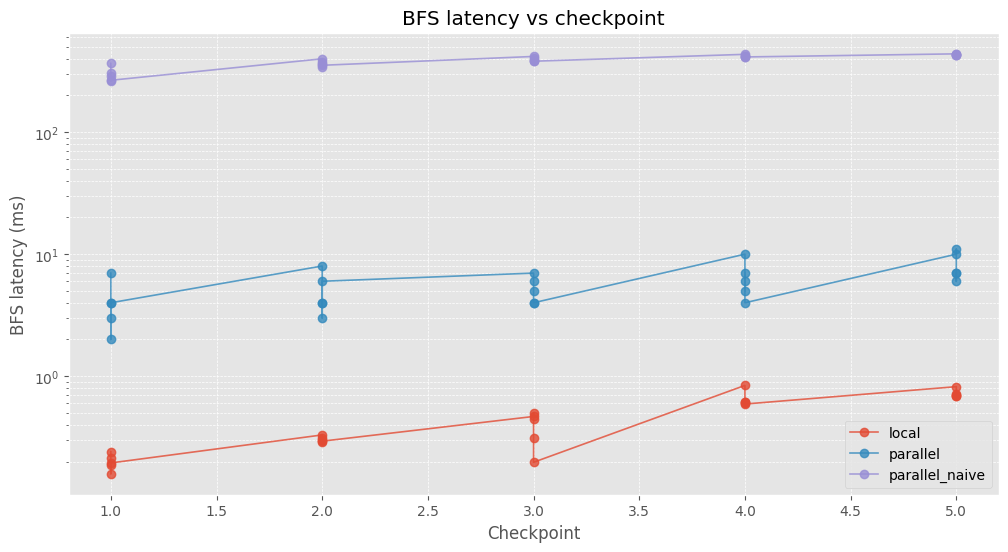

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
for label, group in bfs_df.groupby("dataset"):
    ax.plot(group["checkpoint"], group["rtt_ms"], marker="o", linewidth=1.2, alpha=0.8, label=label)

ax.set_xlabel("Checkpoint")
ax.set_ylabel("BFS latency (ms)")
ax.set_yscale("log")
ax.set_title("BFS latency vs checkpoint")
ax.legend()
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Save the plot
plot_path = DATA_ROOT / "bfs_latency_vs_checkpoint.png"
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
print(f"Saved plot to {plot_path}")
plt.show()


Saved plot to /home/parshan/tinygraph/bfs_latency_by_start_vertex.png


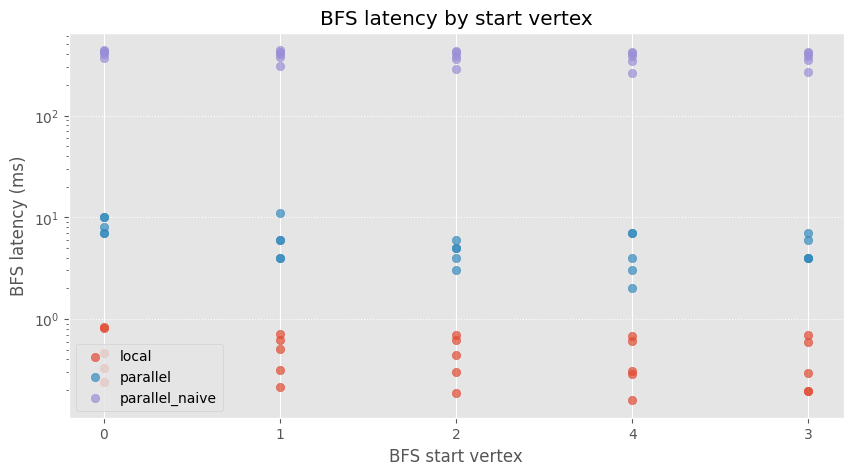

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
for label, group in bfs_df.groupby("dataset"):
    ax.scatter(group["bfs_start"], group["rtt_ms"], alpha=0.7, label=label)

ax.set_xlabel("BFS start vertex")
ax.set_ylabel("BFS latency (ms)")
ax.set_title("BFS latency by start vertex")
ax.set_yscale("log")
ax.legend()
ax.grid(axis="y", linestyle=":")

# Save the plot
plot_path = DATA_ROOT / "bfs_latency_by_start_vertex.png"
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
print(f"Saved plot to {plot_path}")
plt.show()


In [16]:
checkpoint_comparison = (
    bfs_df.pivot_table(index="checkpoint", columns="dataset", values="rtt_ms")
    .rename(columns={"local": "local_ms", "parallel": "parallel_ms"})
)
checkpoint_comparison["parallel_vs_local_pct"] = (
    (checkpoint_comparison["parallel_ms"] - checkpoint_comparison["local_ms"]) / checkpoint_comparison["local_ms"]
) * 100
checkpoint_comparison.head()


dataset,local_ms,parallel_ms,parallel_naive,parallel_vs_local_pct
checkpoint,,,,
1,0.199,4.000,298.000,1911.492
2,0.305,5.000,366.000,1539.026
3,0.385,5.200,394.200,1252.198
4,0.654,6.400,419.000,878.605
5,0.724,8.200,431.600,1032.641


In [17]:
pct_stats = checkpoint_comparison["parallel_vs_local_pct"].describe().to_frame(name="pct_diff")
display(pct_stats)


,pct_diff
count,5.000
mean,1322.792
std,412.249
min,878.605
25%,1032.641
50%,1252.198
75%,1539.026
max,1911.492


## Next steps
- Repeat with additional parallel runs (e.g., `benchmark_parallel_run*.json`) to validate consistency.
- Experiment with different `bfs_radius` values to see how sensitivity changes across datasets.
- Overlay shard/worker level metrics once available to pinpoint hotspots contributing to higher latencies.


In [18]:
# Save checkpoint comparison table to CSV
checkpoint_comparison_path = DATA_ROOT / "checkpoint_comparison.csv"
checkpoint_comparison.to_csv(checkpoint_comparison_path)
print(f"Saved checkpoint comparison table to {checkpoint_comparison_path}")
display(checkpoint_comparison)


Saved checkpoint comparison table to /home/parshan/tinygraph/checkpoint_comparison.csv


dataset,local_ms,parallel_ms,parallel_naive,parallel_vs_local_pct
checkpoint,,,,
1,0.199,4.000,298.000,1911.492
2,0.305,5.000,366.000,1539.026
3,0.385,5.200,394.200,1252.198
4,0.654,6.400,419.000,878.605
5,0.724,8.200,431.600,1032.641
